# PCA on Stations

*Last edit 8/15*

This notebook shows how I used PCA to better understand what kinds of stations there are, in terms of their crowdedness patterns.

TODO: Refactor into functions without harming the story of the analysis. Add more English description to make the story clear.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
import sys
sys.path.append('../src/')
import aposch_functions as aposch

#### Get df04_train dataset

In [3]:
# read in data
data2019 = pd.read_csv('../data/2019_RAW_APC_Data.csv.gz')

# get df04
df04 = aposch.clean_data(data2019)

# split into test/train sets
df04_train, df04_test = train_test_split(df04,
                                         test_size=0.2,
                                         random_state=19)

## Create dataset for PCA

In [4]:
# Group passwithin by Hour, DOY, and station (stadir_ID). Take the mean.
pw_agg = df04_train.groupby(['Hour','DOY','stadir_ID'])['passwithin'].mean()

In [5]:
station_view = pw_agg.reset_index().pivot(index='stadir_ID', columns=['DOY','Hour']).sort_index(axis=1, level='DOY')

In [6]:
station_view.head(3)

passwithin                                                    \
DOY              1                                                       
Hour              0     1   2     3   5         6         7         8    
stadir_ID                                                                
101             -0.5 -14.0 NaN -14.0 NaN -4.000000 -0.333333 -0.142857   
102              0.0   NaN NaN   NaN NaN  5.333333  3.000000  3.000000   
201              9.0  -3.6 NaN   NaN NaN  1.500000  3.500000  4.166667   

                                ...                                         \
DOY                             ...        365                               
Hour              9         10  ...         14     15    16   17        18   
stadir_ID                       ...                                          
101         1.000000 -2.666667  ...   9.000000   0.25  -1.6 -1.0 -8.000000   
102        12.000000  3.500000  ...  13.666667   5.75  12.5  3.0  4.333333   
201         7.333333  5.200000  ...  12.000000  10.50  10.0  8.0 -1.400000   

                                                       
DOY                                                    
Hour         19         20         21         22   23  
stadir_ID                                              
101         6.0   0.000000   5.333333  -5.000000  1.0  
102        20.5  10.666667  13.500000  13.666667  5.0  
201         6.0   5.000000  12.333333   9.000000  NaN  

[3 rows x 8002 columns]

In [7]:
station_view.isna().sum().sum()

23372

In [8]:
station_view.shape[0] * station_view.shape[1]

256064

About 8% of entries in this matrix are NaN.

In [9]:
# Try filling NaNs with 0
station_view_fill0 = station_view.fillna(0)
station_view_fill0.head(3)

passwithin                                                      \
DOY              1                                                         
Hour              0     1    2     3    5         6         7         8    
stadir_ID                                                                  
101             -0.5 -14.0  0.0 -14.0  0.0 -4.000000 -0.333333 -0.142857   
102              0.0   0.0  0.0   0.0  0.0  5.333333  3.000000  3.000000   
201              9.0  -3.6  0.0   0.0  0.0  1.500000  3.500000  4.166667   

                                ...                                         \
DOY                             ...        365                               
Hour              9         10  ...         14     15    16   17        18   
stadir_ID                       ...                                          
101         1.000000 -2.666667  ...   9.000000   0.25  -1.6 -1.0 -8.000000   
102        12.000000  3.500000  ...  13.666667   5.75  12.5  3.0  4.333333   
201         7.333333  5.200000  ...  12.000000  10.50  10.0  8.0 -1.400000   

                                                       
DOY                                                    
Hour         19         20         21         22   23  
stadir_ID                                              
101         6.0   0.000000   5.333333  -5.000000  1.0  
102        20.5  10.666667  13.500000  13.666667  5.0  
201         6.0   5.000000  12.333333   9.000000  0.0  

[3 rows x 8002 columns]

#### Figure out which hours have very few observations, and remove them.

Below we see that there are very few DOW-stadir combos that have any observations in the 1:00, 2:00 or 3:00 hours. It's also rather scarce in the 4:00 hour.

Because of this, I will remove the 1am thru 4am hours. This way, the station_view dataframe will have much fewer NaNs.

In [10]:
dfo = pd.DataFrame({'Hour':[x[0] for x in pw_agg.index],
                    'DOW':[x[1] for x in pw_agg.index],
                    'stadir_ID':[x[2] for x in pw_agg.index]})
dfo.groupby('Hour').count()

,DOW,stadir_ID
Hour,,
0,8160,8160
1,1960,1960
2,1040,1040
3,1116,1116
4,4716,4716
5,10184,10184
6,11394,11394
7,11487,11487
8,11530,11530


Remove 1 o'clock hour thru 4 o'clock hour:

In [11]:
hour = pd.Series(data=[x[2] for x in station_view.columns],
                 index=station_view.columns)
filt = ~hour.between(1,4)

# Station view
station_view_filt = station_view.loc[:,filt]

Fill NaNs by interpolating:

In [12]:
# Fill NaNs by interpolating before and after
station_view_ipl = station_view_filt.interpolate(method='linear', axis=1)
station_view_ipl.head(3)

passwithin                                                     \
DOY              1                                                        
Hour              0         5         6         7         8          9    
stadir_ID                                                                 
101             -0.5 -2.250000 -4.000000 -0.333333 -0.142857   1.000000   
102              0.0  2.666667  5.333333  3.000000  3.000000  12.000000   
201              9.0  5.250000  1.500000  3.500000  4.166667   7.333333   

                                              ...                          \
DOY                                           ...        365                
Hour             10        11        12   13  ...         14     15    16   
stadir_ID                                     ...                           
101       -2.666667  1.333333 -1.200000 -1.5  ...   9.000000   0.25  -1.6   
102        3.500000  7.750000  8.200000  5.0  ...  13.666667   5.75  12.5   
201        5.200000  3.500000  2.714286  1.5  ...  12.000000  10.50  10.0   

                                                                      
DOY                                                                   
Hour        17        18    19         20         21         22   23  
stadir_ID                                                             
101       -1.0 -8.000000   6.0   0.000000   5.333333  -5.000000  1.0  
102        3.0  4.333333  20.5  10.666667  13.500000  13.666667  5.0  
201        8.0 -1.400000   6.0   5.000000  12.333333   9.000000  9.0  

[3 rows x 7288 columns]

## Run the PCA algorithm

Here I'm doing PCA on the interpolation-filled dataframe.

In [13]:
pca01 = PCA(n_components=0.95, svd_solver='full')

station_pc = pca01.fit_transform(station_view_ipl)

C:\Users\augus\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [14]:
#station_pc
pca01.explained_variance_ratio_

array([0.44158736, 0.39263624, 0.04199495, 0.02983978, 0.01549915,
       0.00817071, 0.00638198, 0.0059527 , 0.00536735, 0.00430558])

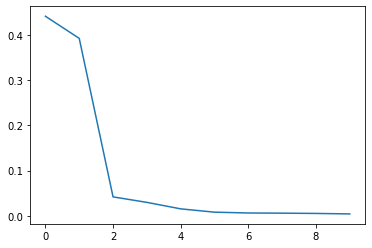

In [15]:
plt.plot(pca01.explained_variance_ratio_)

We have 44% of variance explained by the first PC, and 39% of variance explained by the second PC. Then it goes 4%, 3%, 2%, 1%...

Make a simple plot of stations in PC-space:

<AxesSubplot:>

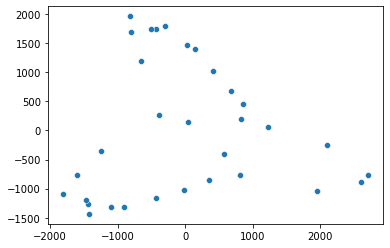

In [16]:
sns.scatterplot(x=station_pc[:,0], y= station_pc[:,1])

Such an interesting shape! Call it a butterfly.

What this means is that the stations don't naturally cluster into a couple types.

## Investigate the butterfly pattern

Make a dataframe to investigate this.

In [17]:
# station_pc_investigation

station_pci = pd.DataFrame(data=station_pc[:,[0,1]], index=station_view.index, columns=['PC1','PC2'])

df = station_pci
northbound = [102,203,304,405,506,607,708,809,910,1011,1112,1213,1314,1415,1516,1616]

df['Northbound'] = np.where(df.index.isin(northbound), 1, 0)

df['ID'] = df.index

df['RouteProgress']= np.where(df['Northbound'],
                             np.round(df['ID'],-2)//100,
                             np.round(1700-df['ID'],-2)//100)

df['Station'] = np.round(df['ID'],-2)//100

df

,PC1,PC2,Northbound,ID,RouteProgress,Station
stadir_ID,,,,,,
101,2705.453104,-772.615413,0,101,16,1
102,1959.477314,-1041.345968,1,102,1,1
201,2103.972703,-250.251841,0,201,15,2
203,815.870148,-761.306741,1,203,2,2
302,1222.990035,66.060693,0,302,14,3
304,358.578858,-852.108610,1,304,3,3
403,852.628863,457.057943,0,403,13,4
405,-9.654305,-1015.279566,1,405,4,4
504,677.030346,683.504320,0,504,12,5


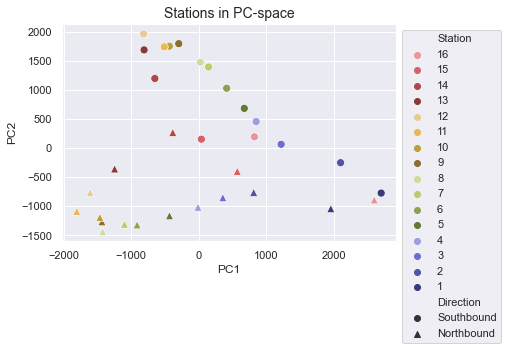

In [18]:
sns.set_theme()
ax = sns.scatterplot(data=station_pci, x='PC1', y='PC2', hue='Station',
                     style='Northbound', 
                     markers=('o','^'),
                     alpha=1,
                     palette='tab20b',
                     s=64)
handles, labels = ax.get_legend_handles_labels()
legend_order = [0,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,17,18,19]
handles_lo = [handles[x] for x in legend_order]
labels_lo = [labels[x] for x in legend_order]
labels_lo[-3:-1] = ['Direction','Southbound','Northbound']
ax.legend(handles_lo, labels_lo)
sns.move_legend(ax, "upper left", bbox_to_anchor = (1,1))
plt.title('Stations in PC-space', size=14)
plt.savefig('../images/PCA_stations.png', bbox_inches='tight')

The train route traces the (lower-)left wing of the butterfly going Northbound, and traces the (upper-)right wing of the butterfly going Southbound. In this PC-space, stations 15 and 16 are closer to stations 1,2,3, and 4 - and stations 15 and 16 are against the body of the butterfly.

Let's look at the PC loadings to know what's going on:

In [19]:
loadings = pd.DataFrame(pca01.components_[:2].T, columns=['PC1', 'PC2'], index=station_view_ipl.columns)

In [20]:
loadings.sort_values('PC1')

PC1       PC2
           DOY Hour                    
passwithin 181 10   -0.035932 -0.030334
           309 8    -0.034010 -0.022471
           292 10   -0.032917 -0.039308
               11   -0.031876 -0.030624
           243 10   -0.031830 -0.043968
...                       ...       ...
           303 0     0.000821  0.001285
           283 0     0.000963  0.000700
           311 0     0.001129  0.003326
           205 0     0.001266  0.003053
           163 19    0.001679  0.029854

[7288 rows x 2 columns]

In [21]:
loadings.sort_values('PC2')

PC1       PC2
           DOY Hour                    
passwithin 243 10   -0.031830 -0.043968
           292 10   -0.032917 -0.039308
           243 9    -0.024982 -0.036622
           333 10   -0.026938 -0.033413
           243 11   -0.030303 -0.031838
...                       ...       ...
           268 17   -0.011759  0.039071
           319 16   -0.009511  0.039390
           330 17   -0.014446  0.039622
           331 16   -0.007240  0.046043
           256 21   -0.003866  0.049196

[7288 rows x 2 columns]

## Conclusions

Based on the top 5 and bottom 5 DOY-Hour combos for each PC, we can paint a vignette:

Positive PC1: late-night midweek -ness
Negative PC1: weekend morning -ness
Positive PC2: weekday evening rush-hour -ness  
Negative PC2: weekend morning -ness

Higher values of PC1 happen when weekend mornings are less crowded and midweek late-nights are more crowded.

Higher values of PC2 happen when weekend mornings are less crowded and weekday evening rush-hours are more crowded.

Looking back at the plot:
- Higher values of PC1 happen at the first couple and last couple stations, i.e. the northernmost and southernmost stations, i.e. the outer stations. Lower values of PC1 happen in the middle of the trip, applying to most of the stations, i.e. the city center.
- Higher values of PC2 happen for Southbound, especially for Southbound city center stations. Lower values happen for most Northbound stations.

Conclusions from plot:
- PC1 mostly captures city center stations versus outer stations.
- PC2 mostly captures Northbound vs Southbound.

Conclusions from loadings:
  - (from PC2) On weekend mornings, Northbound stops may be more crowded than Southbound.
  - (from PC1) On weekend mornings, city center stops may be more crowded than outer stops.
  - (from PC2) On weekday 4-6pm times, Southbound stops may be more crowded than Northbound stops.
  - (from PC1) On weekday late-nights, outer stops may be more crowded than city center stops.
    - This is explained by the the airport stop and the college stop at either end - both would spur late-night crowds!
